# Natural Language Processing for the Fake News Challenge

## Main Imports

In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from joblib import dump, load
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, make_pipeline, make_union
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [3]:
!pip install transformers
import transformers

     |████████████████████████████████| 2.1MB 8.6MB/s 
     |████████████████████████████████| 870kB 35.2MB/s 
     |████████████████████████████████| 3.3MB 22.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=75c917e864bb73ba6cf478881df53f25d0956f56dc4b16044451618371be4834
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


## Set up the data for preprocessing
### Load and sample the data

In [5]:
data_folder_name = 'data'
train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'

train_body_path = data_folder_name +'/'+ train_body_filename 
train_stance_path = data_folder_name + '/' + train_stance_filename

body_data = pd.read_csv(train_body_path)
stance_data = pd.read_csv(train_stance_path)

In [9]:
body_data.sample(10)

,Body ID,articleBody
913,1368,Jeny Chang for BuzzFeed / Via Drug Policy Alli...
1135,1718,"Dan Olsen, a former-ish PGA Golfer, went on Th..."
1359,2047,"According to multiple reports, ISIS claims to ..."
1162,1756,KIM Jong-un could try and open a restaurant in...
1009,1517,A Macedonian man sliced off his own dick and a...
212,345,"UTAH COUNTY — Over the years, holiday office C..."
815,1224,ISIS released a video purportedly showing the ...
921,1377,An article saying a “planetary alignment” on J...
542,817,It’s been more than a month since North Korean...
735,1103,"When most parents think of a school trip, they..."


### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies

In [6]:
total_data = pd.merge(body_data, stance_data, on='Body ID')

# randomly drop rows to improve performance on SVM
remove_n = 0
drop_indices = np.random.choice(total_data.index, remove_n, replace=False)
total_data = total_data.drop(drop_indices)

# add relevance column
total_data['Relevance'] = np.where(total_data['Stance'] == 'unrelated', 'unrelated', 'related')
total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
14904,891,A US airstrike allegedly killed ISIS leader Al...,Kimye’s Fault? Anna Wintour’s NYC ‘Vogue’ Offi...,unrelated,unrelated
36635,1949,"There it was in the middle of a field, baking ...",U.S. accidentally delivered weapons to the Isl...,discuss,related
32155,1790,(Reuters) - A mysterious late-night blast in t...,Large space object slams Nicaragua’s capital a...,discuss,related
48746,2480,A tour of the royal grounds at Buckingham Pala...,WSJ: Apple cut watch health features due to er...,unrelated,unrelated
26658,1500,Tonight — finally! — ESPN is going to have an ...,US hostage Luke Somers dies after rescue bid,unrelated,unrelated
45683,2343,"Oscar-winner Christian Bale, who has played Ba...",Christian Bale to Play Steve Jobs in New Movie,discuss,related
39630,2096,Islamic State militants have released a graphi...,Continuing Violence Puts Boko Haram Ceasefire ...,unrelated,unrelated
48760,2481,An audio recording released Tuesday morning ma...,Report: Audio Reveals Pause Between Gunshots W...,discuss,related
17139,1012,Rep. Duncan Hunter (R-CA) told Greta Van Suste...,This Is Why Rumors That ISIS Is Crossing The B...,discuss,related
14381,855,U.S. Rep. Duncan Hunter this week declared ter...,Jeh Johnson shoots down Duncan Hunter's assert...,agree,related


### Splitting the dataset into train and validation sets

In [7]:
input_columns = total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(input_columns, total_data[target].values , test_size=0.20, random_state=0)

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)


,Headline,articleBody
23146,Saddam Hussein’s pilots training Islamic State...,"By Sylvia Westall\n\nBEIRUT, Oct 17 (Reuters) ..."
10934,Isis Syria News: Video Shows US Airdropped Wea...,Homeland Security Secretary Jeh Johnson says I...
13026,New Audio Allegedly Captures Moment Michael Br...,SIS has developed a new weapon in Iraq designe...
45402,North Korea dictator Kim Jong-un undergoes sur...,Seattle/ San Francisco: Google Inc. bought six...
38398,Comcast Says You Can Keep Your Tor,A married TV actor who met a young woman and k...
40499,Meteorite leaves crater in Nicaraguan capital ...,The United States appears to now be flying una...
38458,An Audio Recording of the Michael Brown Shooti...,A married TV actor who met a young woman and k...
47358,Unconfirmed reports claim Canadian-Israeli Gil...,A schoolboy almost killed by an electric shock...
28465,"ISIS Claims Female American Hostage, Kayla Mue...",Boko Haram has denied claims by Nigeria's gove...
4868,Sugarhill Gang rapper Big Bank Hank dies aged 57,The wife and child of the Abu Bakr al-Baghdadi...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [12]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [15]:
# feature extraction with TF-IDF

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=200, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=200, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
train = preprocessor.fit_transform(X_train)
val = preprocessor.transform(X_val)
print('Train size: ', train.shape)
print('Val size: ', val.shape)

Train size:  (39977, 400)
Val size:  (9995, 400)


# Tokenisation with BERT

## Load the model and tokeniser

In [8]:
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [10]:
tokenized = tokenizer(list(X_train['Headline']), list(X_train['articleBody']), padding=True, truncation=True, return_tensors="pt")
print(tokenized)

{'input_ids': tensor([[  101,  2038,  5035,  ...,  1010,  2225,   102],
        [  101,  4604,  1999,  ...,     0,     0,     0],
        [  101,  2040,  2323,  ...,     0,     0,     0],
        ...,
        [  101, 18301,  1005,  ...,     0,     0,     0],
        [  101,  2156,  1996,  ...,     0,     0,     0],
        [  101, 19600,  5283,  ...,  1012,  2070,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])}


## Evaluation Metrics

### Confusion Matrix

In [ ]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [ ]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Training Models

### Naive Bayes

In [ ]:
# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(train, y_train)
print("train score:", model.score(train, y_train))
print("validation score:", model.score(val, y_val))

train score: 0.7339970483027741
validation score: 0.7237618809404702


### Support Vector Machine Classifier

In [ ]:
# training an SVM on TF-IDF features
# Define the parameters to tune

start = time.time()
parameters = {
    'C': [1, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(train, y_train)
end = time.time()
print(end - start, "seconds")
dump(model, 'SVM.joblib') 

7253.770225524902 seconds


['SVM.joblib']

              precision    recall  f1-score   support

     related       0.97      0.97      0.97      2767
   unrelated       0.99      0.99      0.99      7228

    accuracy                           0.98      9995
   macro avg       0.98      0.98      0.98      9995
weighted avg       0.98      0.98      0.98      9995



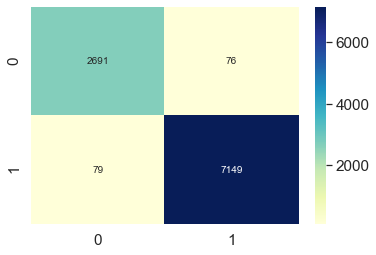

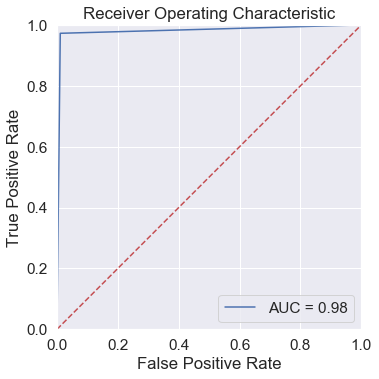

In [ ]:
y_pred = model.predict(val)

print(metrics.classification_report(y_val, y_pred))
plot_confussion_matrix(y_val, y_pred)

# convert to 0s and 1s for plotting ROC curve
roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

plot_roc_curve(roc_y_val, roc_y_pred)